# [1]Importing Libraries

In [17]:
from PIL import Image
import itertools
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
import pickle
#Deep-Learning Library
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')

In [ ]:
print ("Number of Data Points :", data.shape[0])
print ("Number of Features /Variables:" ,data.shape[1])


In [ ]:
data.columns

Of these 19 features, we will be using only 6 features in this project.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [ ]:
data= data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
print ("Number of Data Points :", data.shape[0])
print ("Number of Features /Variables:" ,data.shape[1])
data.head()

# [2]Missing data values for various features

Now we will find the basic stats for each various feature for Data cleaning and storing it

####  [2.1]Basic stats for the feature: product_type_name

In [ ]:
print(data['product_type_name'].describe())

In [ ]:
# names of different product types
print(data['product_type_name'].unique())
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

#### [2.2]Basic stats for the feature: brand

In [ ]:
print(data['brand'].describe())

As we can see that there are only 10577 unique brands and total missing brands are 183138-182987=151

In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

Thge Most common Brand is Zago

####  [2.3]Basic stats for the feature: color

In [ ]:
print(data['color'].describe())
color_count = Counter(list(data['color']))
color_count.most_common(10)

###### As we can see 7380 are unique product.
###### 64956 of 183138 products have color information. That's approx 35.4%.
###### 7.2% of products are black in color

#### [2.4] Basic stats for the feature: formatted_price

In [ ]:
print(data['formatted_price'].describe())
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

###### Only 28,395 (15.5% of whole data) products with price information

#### [2.5]Basic stats for the feature : title

In [ ]:
print(data['title'].describe())

In [ ]:
data.to_pickle('pickels/180k_apparel_data')

To reduce this large data we will take formatted price such that our null entries are removed for better data frame

In [ ]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Now taking color in it for removing null in the color section

In [ ]:
data = data.loc[~data['color'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

In [ ]:
data.to_pickle('pickels/28k_apparel_data')

I have reduced the to 28K because i want to understand some basics operation on small data first so 28k is enough for understanding it .For those who want to work on the 180K data can work on it.I have commented out the code for image 28K data so those who are usiung this can download it from here.

In [ ]:
'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

# [3] Removing the duplicated Items by Title name

#### [3.1] Understanding the Duplicates

In [ ]:
data = pd.read_pickle('pickels/28k_apparel_data')

In [ ]:
print(sum(data.duplicated('title')))

we have 2325 products which have same title but different color

#### [3.2] Remove Duplicates : Part 1

In [ ]:
data = pd.read_pickle('pickels/28k_apparel_data')
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
data.head()

In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [ ]:
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

##### Some examples of dupliacte titles that differ only in the last few words.

Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large


In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points : ', data.shape[0])

In [ ]:
data.to_pickle('pickels/17k_apperal_data')

##### Some examples of dupliacte titles that differ only in the between few words.


In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt


The Method below mentioned is brute-force attack method

In [ ]:
data=pd.read_pickle('pickels/17k_apperal_data')
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])
data.to_pickle('pickels/16k_apperal_data')

In [ ]:
data.head()

# [4] Data Pre processing using Stop word removal

In [ ]:
data = pd.read_pickle('pickels/16k_apperal_data')
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string


In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

In [ ]:
data.head()

In [ ]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

In [ ]:
data=pd.read_pickle('pickels/16k_apperal_data_preprocessed')
print(data.shape[0])

In [ ]:
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

As in the above we can see that 16435 are titles and 11157 are the word in document corpus

# [5] Creating the IDF weighted Word2Vec Title ,Brand and Color using One Hot Encoder and Visual by VGG16 CovNet.

## [5.1] Defining The Features

### [5.1.1] Idf Title Features and W2V Title Features

In [6]:
data=pd.read_pickle('pickels/16k_apperal_data_preprocessed')
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

### [5.1.2] Defining the Features for Brands and Color

In [7]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]

colors = [x.replace(" ", "-") for x in data['color'].values]

#One-Hot Encoding using Count vectorizer
brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)



## [5.2] Utility Functions for the IDF Word2Vec Weighted Title

In [15]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)
# vocab = stores all the words that are there in google w2v model
vocab = model.keys()
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [14]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [19]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [12]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)


In [10]:
def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

In [11]:


# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec


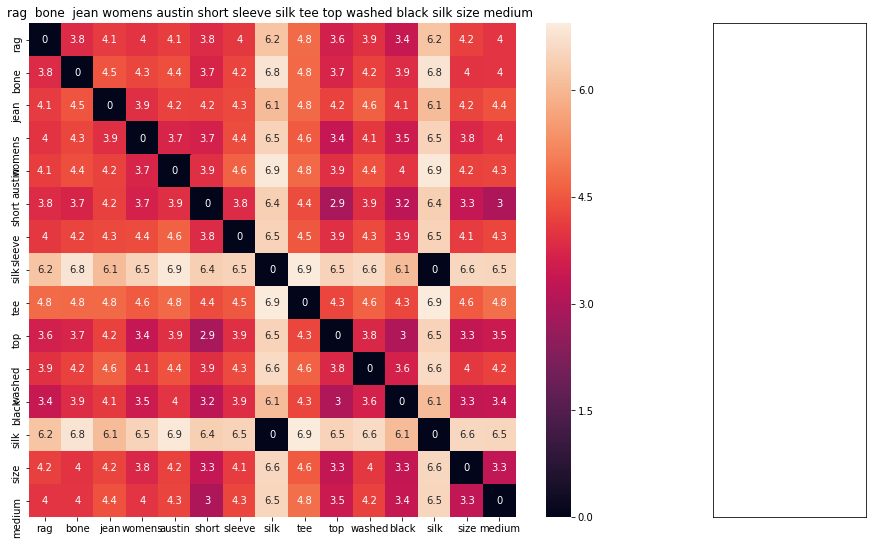

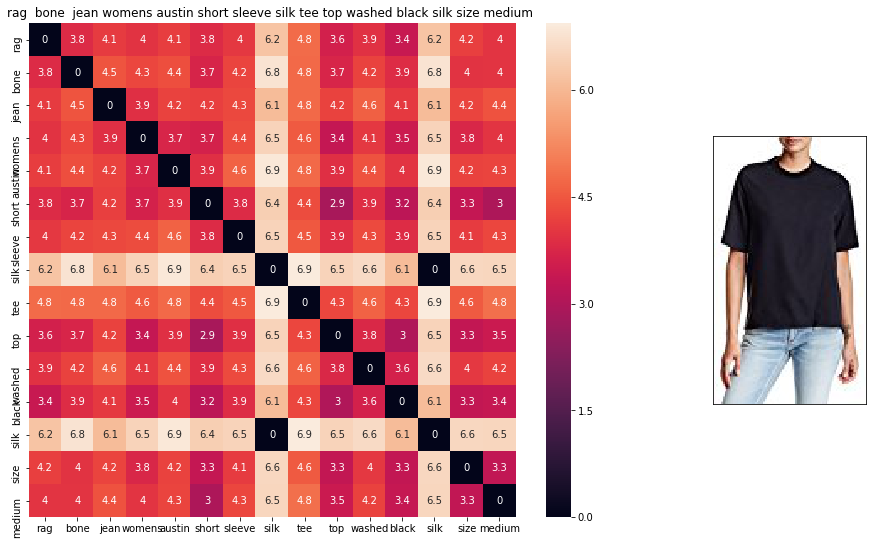

ASIN : B06XDYB1TX
Brand : rag & bone
euclidean distance from input : 0.0


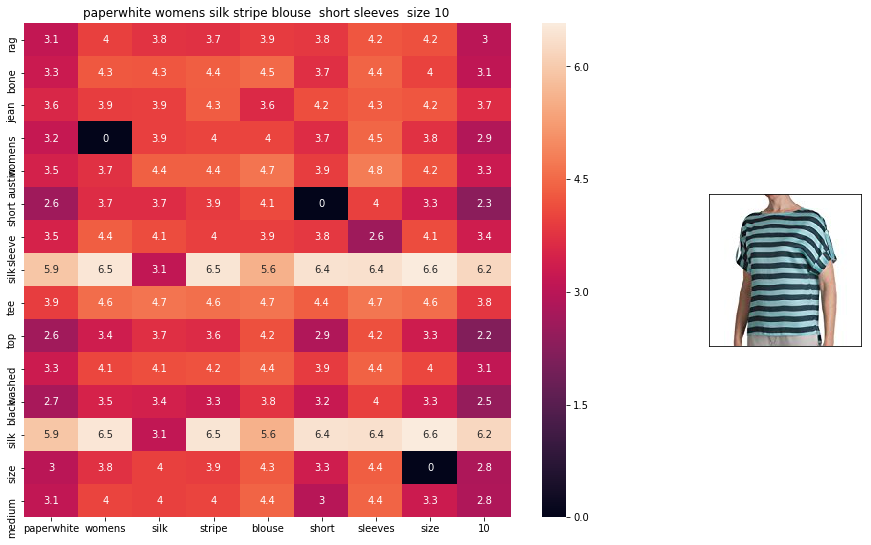

ASIN : B0183IABUE
Brand : Paperwhite
euclidean distance from input : 0.867065


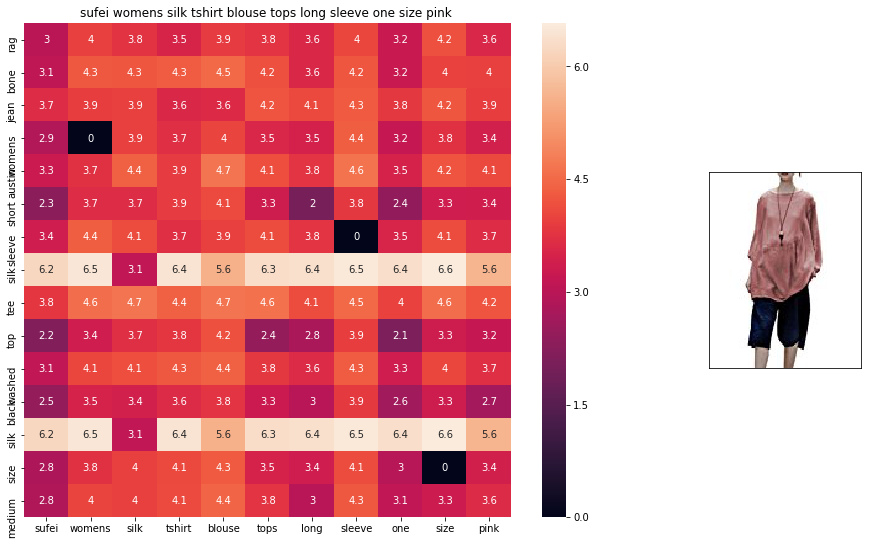

ASIN : B074N68P4F
Brand : Sufei
euclidean distance from input : 0.868683


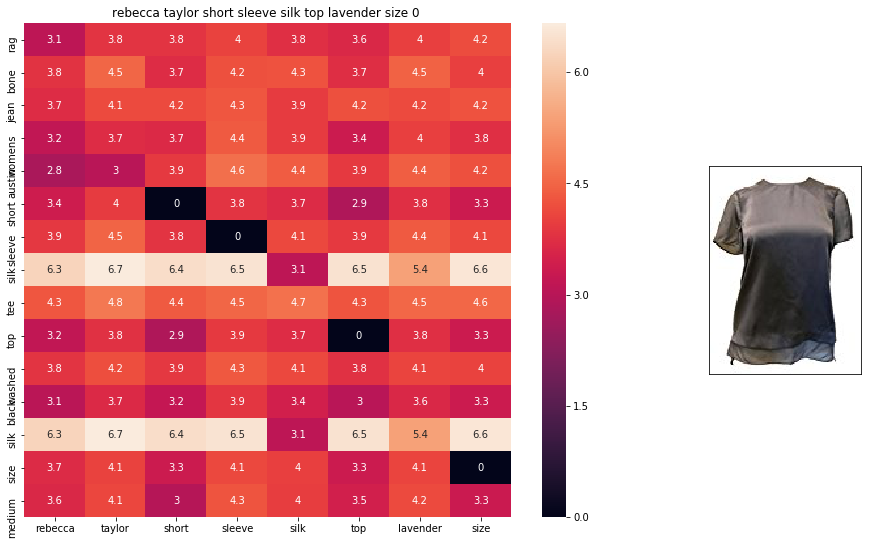

ASIN : B06X9Y8SQF
Brand : Rebecca Taylor
euclidean distance from input : 0.878402


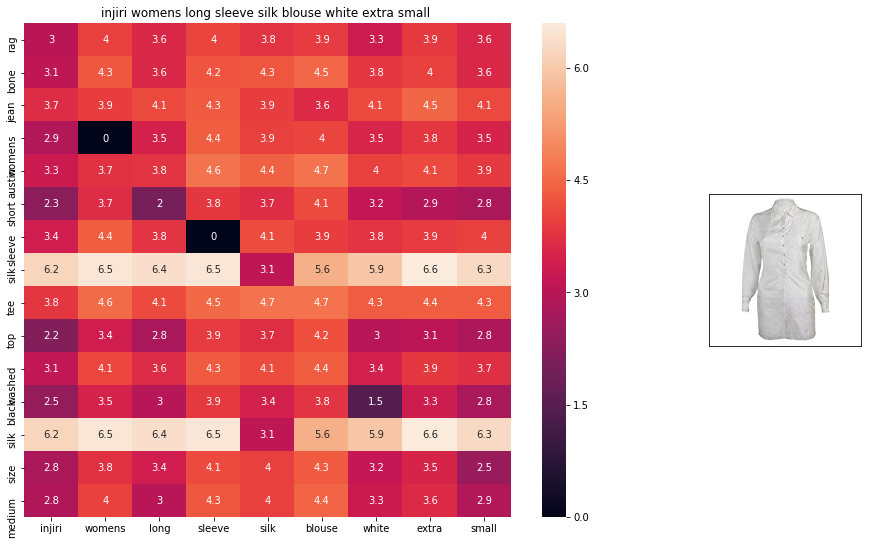

ASIN : B073BMC2KY
Brand : Injiri
euclidean distance from input : 0.878713


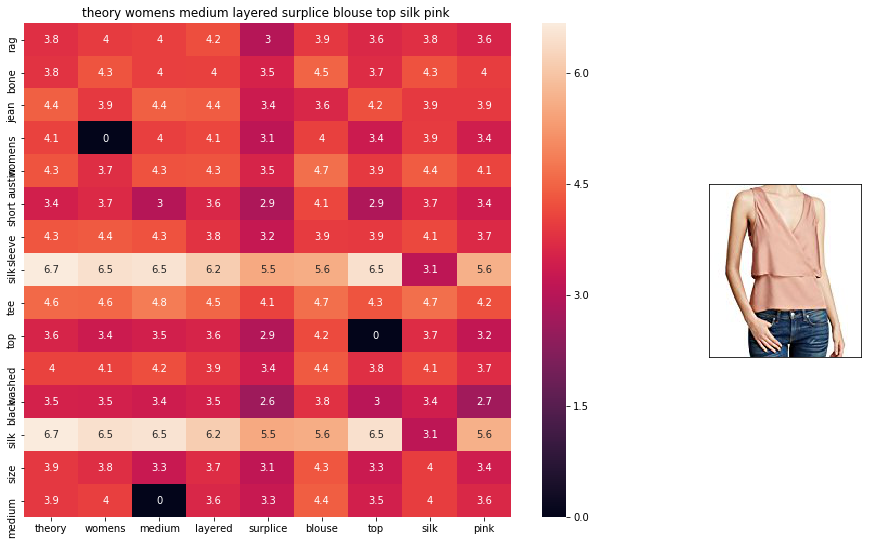

ASIN : B0759DZSK6
Brand : Theory
euclidean distance from input : 0.879778


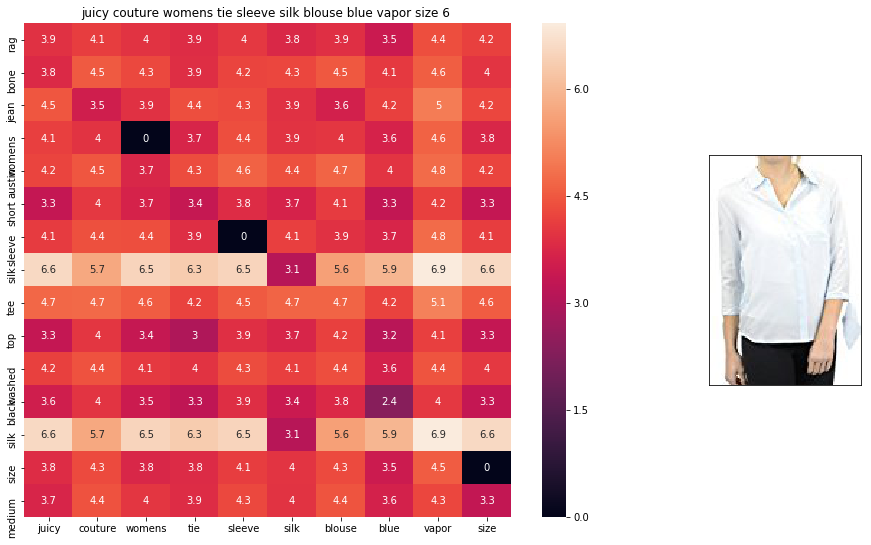

ASIN : B018RMIAAE
Brand : Juicy Couture
euclidean distance from input : 0.887165


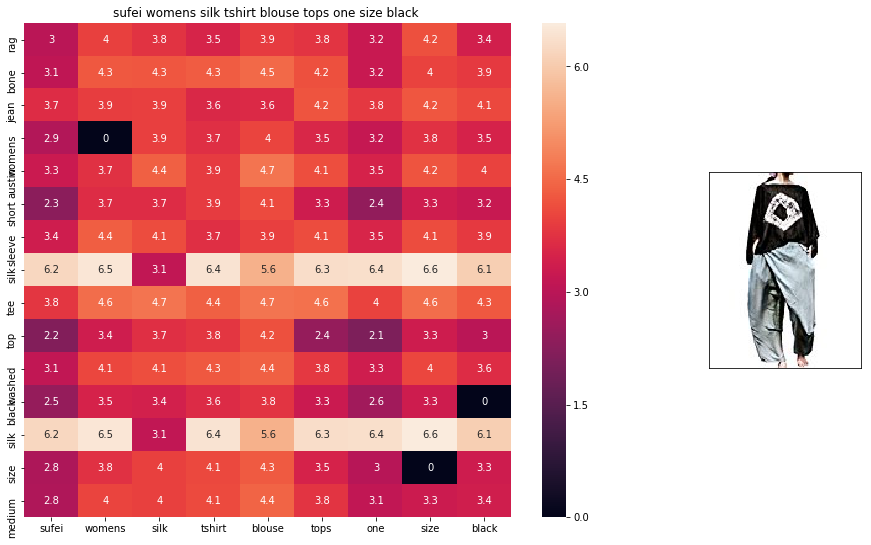

ASIN : B074N6947M
Brand : Sufei
euclidean distance from input : 0.888603


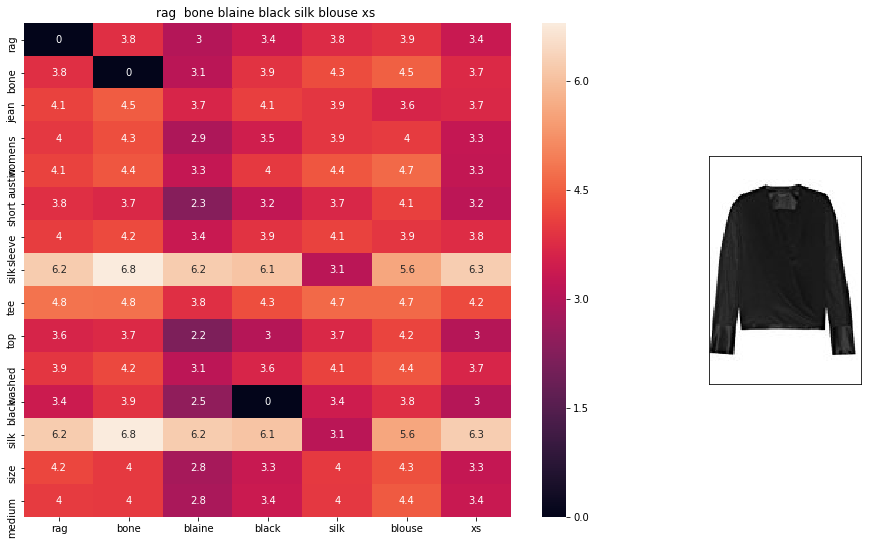

ASIN : B072LDKGBB
Brand : rag & bone
euclidean distance from input : 0.890759


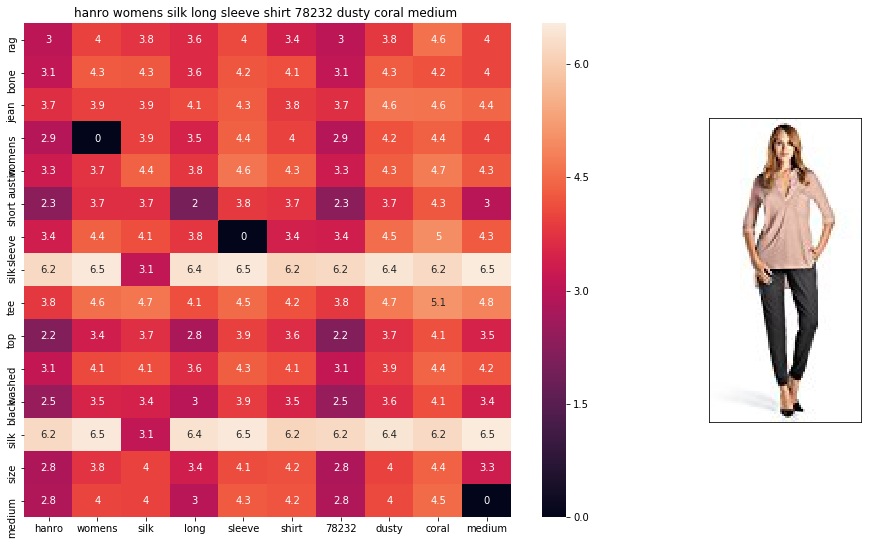

ASIN : B01MCWBRSP
Brand : HANRO
euclidean distance from input : 0.893389


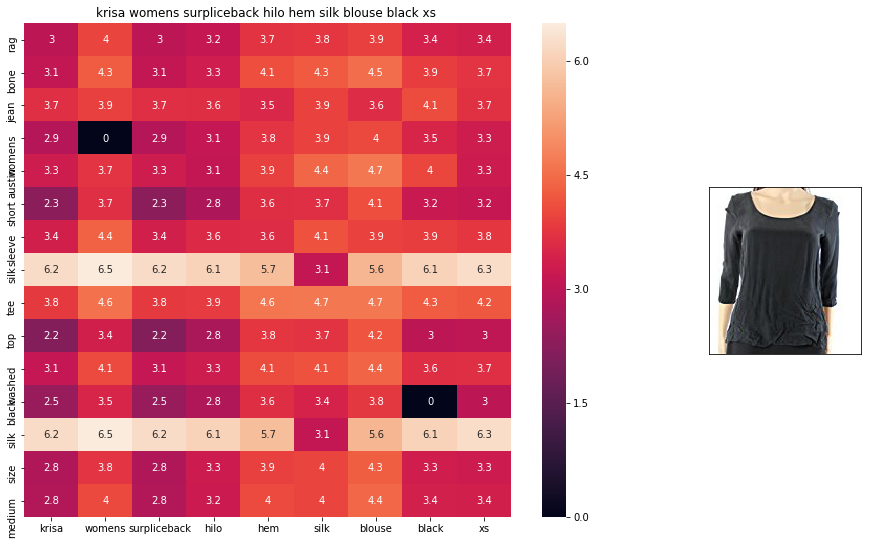

ASIN : B0719R5YZ5
Brand : Krisa
euclidean distance from input : 0.894284


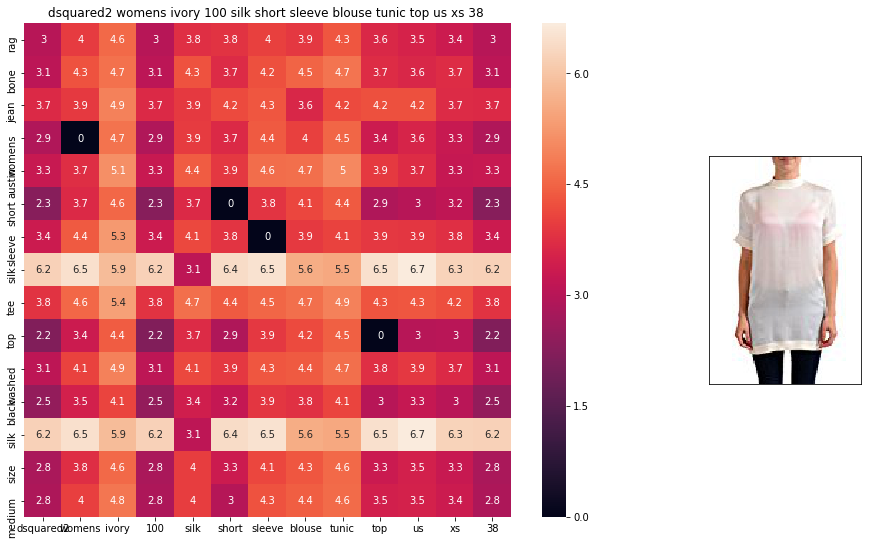

ASIN : B01L61KCHC
Brand : DSQUARED2
euclidean distance from input : 0.899827


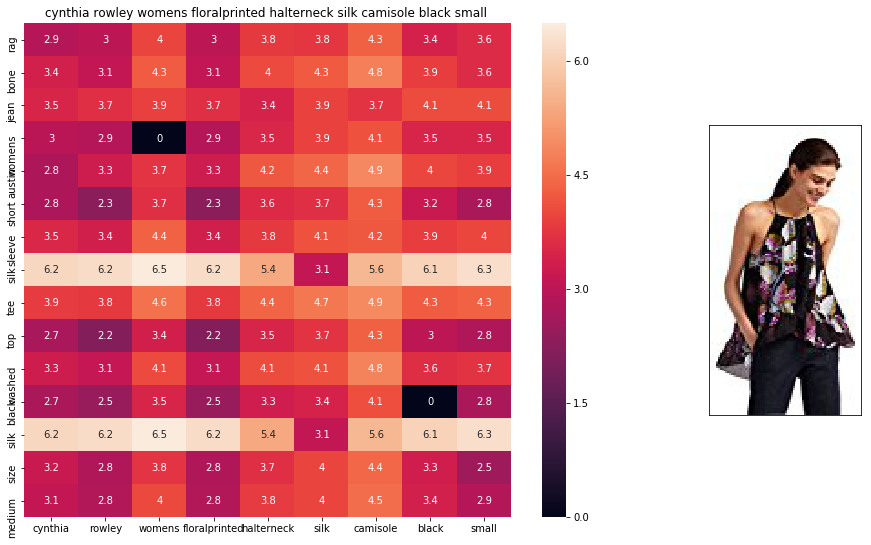

ASIN : B0716TQ2F7
Brand : Cynthia Rowley
euclidean distance from input : 0.904126


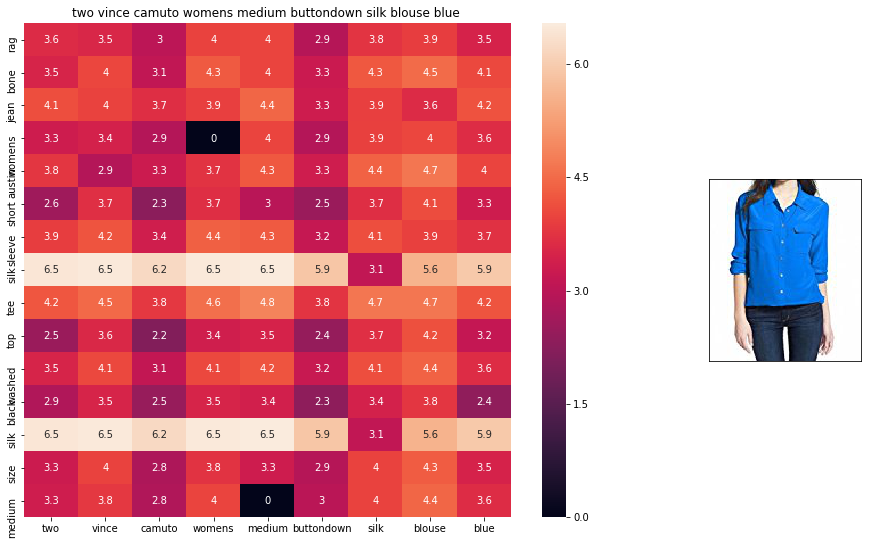

ASIN : B0758G2WFJ
Brand : Two by Vince Camuto
euclidean distance from input : 0.905648


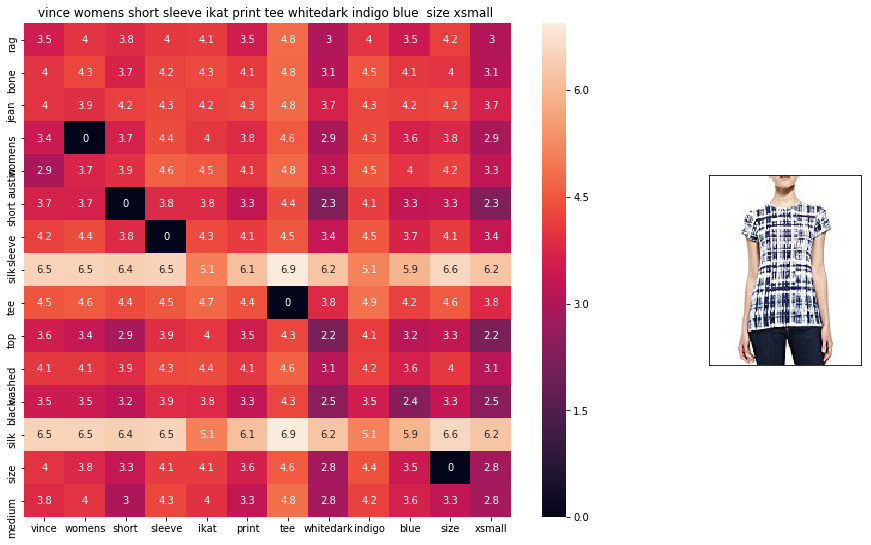

ASIN : B01MQLK2C3
Brand : Vince
euclidean distance from input : 0.911258


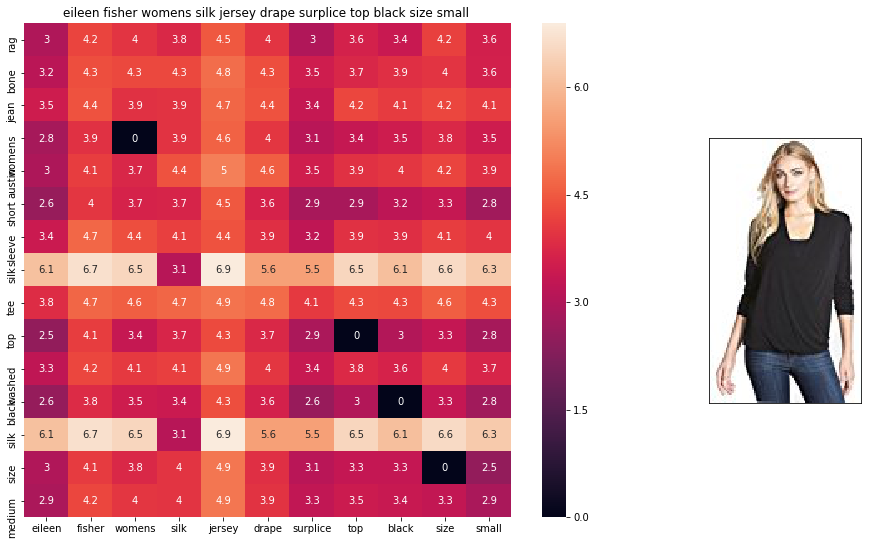

ASIN : B06XWXS4NP
Brand : Eileen Fisher
euclidean distance from input : 0.912166


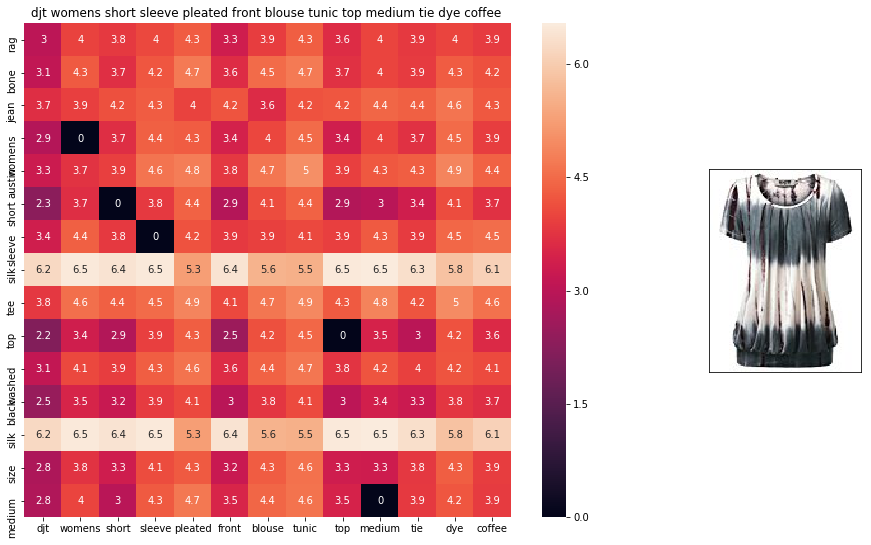

ASIN : B071HFQ68W
Brand : DJT
euclidean distance from input : 0.913636


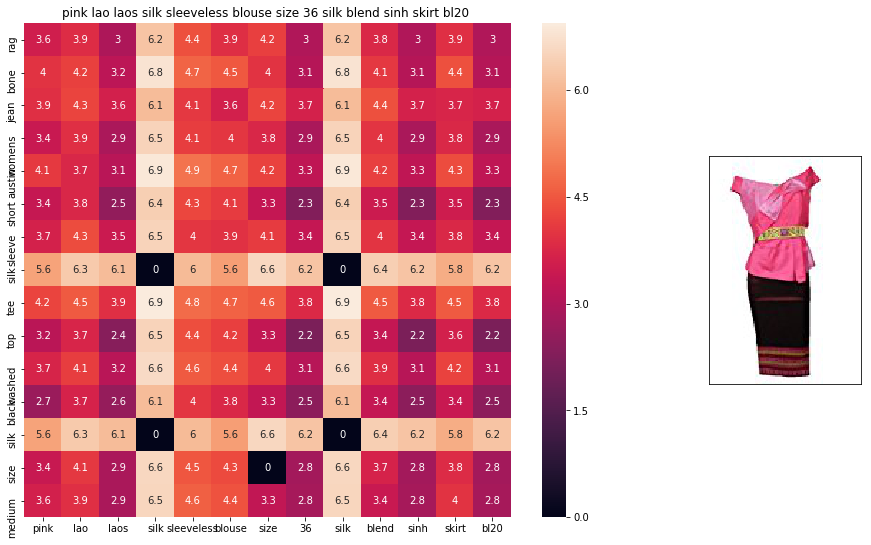

ASIN : B073LV151M
Brand : Mukdahan Craft
euclidean distance from input : 0.914339


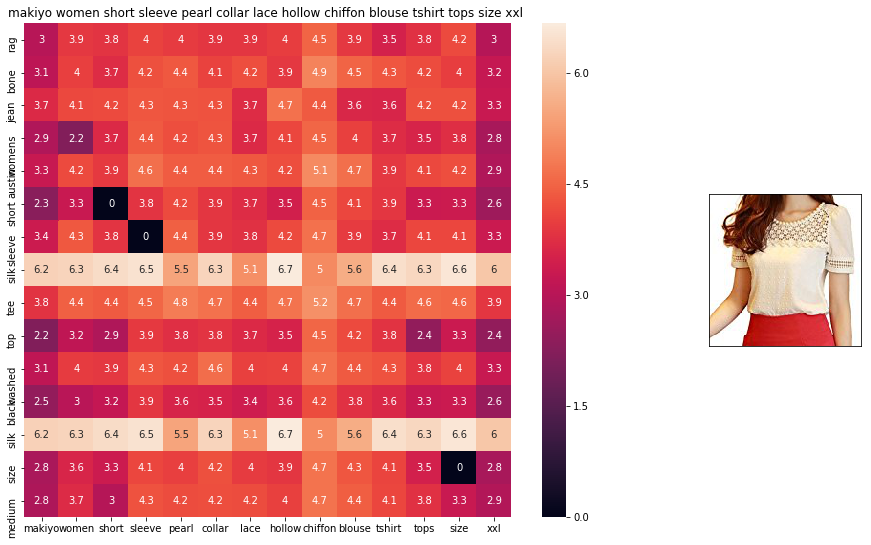

ASIN : B012SQWPYC
Brand : MAKIYO
euclidean distance from input : 0.91484


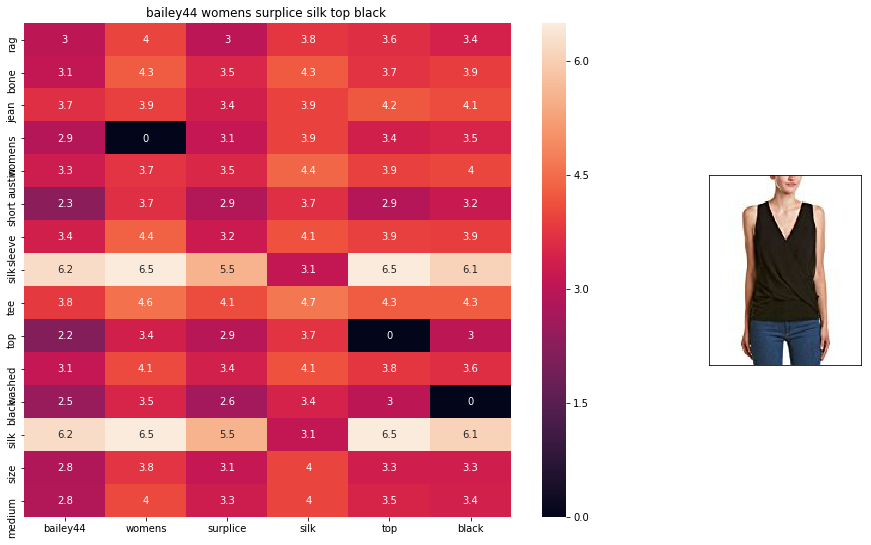

ASIN : B074S83BRV
Brand : Bailey 44
euclidean distance from input : 0.915208


In [18]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
#The Below code is is for the weighted IDF Word2Vec 
def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
weighted_w2v_model(12577,20)

## [5.3] Using VGG16 ConvNet ,Keras and Tensorflow for Image

In [ ]:
'''# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()'''

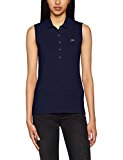

Product Title:  lacoste womens womens navy sleeveles pique polo size 463xl navy 
Euclidean Distance from input image: 0.0765466
Amazon Url: www.amzon.com/dp/B01M3VNRG1


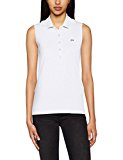

Product Title:  lacoste womens womens white pique polo size 46xxxl white 
Euclidean Distance from input image: 20.7778
Amazon Url: www.amzon.com/dp/B01M2AAJNP


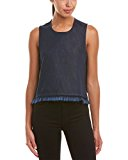

Product Title:  alc womens nina top 4 blue 
Euclidean Distance from input image: 33.1901
Amazon Url: www.amzon.com/dp/B01MPX3OQJ


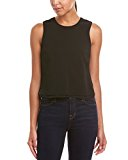

Product Title:  alc womens margaret silkunderlayer top 4 black 
Euclidean Distance from input image: 33.6831
Amazon Url: www.amzon.com/dp/B01M7U5M9S


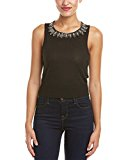

Product Title:  belle badgley mischka womens silkblend sweater l black 
Euclidean Distance from input image: 34.5995
Amazon Url: www.amzon.com/dp/B01N3W4IDC


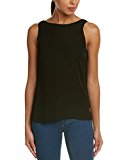

Product Title:  alice  olivia womens eldridge tank black 
Euclidean Distance from input image: 34.6011
Amazon Url: www.amzon.com/dp/B071G2YTJ4


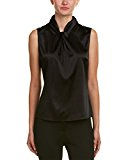

Product Title:  st john womens silkblend top p 
Euclidean Distance from input image: 34.7167
Amazon Url: www.amzon.com/dp/B0753QB584


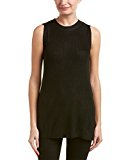

Product Title:  six crisp days womens side slit top xss 
Euclidean Distance from input image: 35.0427
Amazon Url: www.amzon.com/dp/B06XCS9KLC


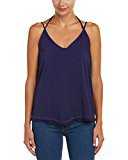

Product Title:  splendid womens double strap cami xl blue 
Euclidean Distance from input image: 35.7605
Amazon Url: www.amzon.com/dp/B0746STR6M


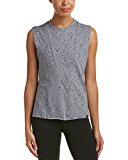

Product Title:  koral womens activewear move crop top xs 
Euclidean Distance from input image: 36.1574
Amazon Url: www.amzon.com/dp/B071XD14DR


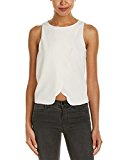

Product Title:  esley womens scalloped blouse l 
Euclidean Distance from input image: 36.1605
Amazon Url: www.amzon.com/dp/B01M716OVC


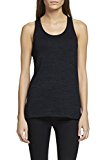

Product Title:  rag  bone womens twist back tank top sz l navy black heather 270874dh 
Euclidean Distance from input image: 36.513
Amazon Url: www.amzon.com/dp/B073WMBN94


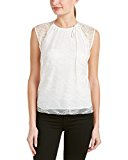

Product Title:  sandro womens epply lace top 2 white 
Euclidean Distance from input image: 36.698
Amazon Url: www.amzon.com/dp/B06XKVT9ZT


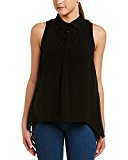

Product Title:  sadie  sage womens aline top black 
Euclidean Distance from input image: 37.0369
Amazon Url: www.amzon.com/dp/B074MJJ2X2


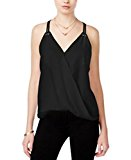

Product Title:  bar iii womens solid racerback casual top black 
Euclidean Distance from input image: 37.0408
Amazon Url: www.amzon.com/dp/B0724ZCX9F


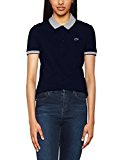

Product Title:  lacoste womens womens navy cotton polo size 42xl blue 
Euclidean Distance from input image: 37.302
Amazon Url: www.amzon.com/dp/B01MG65GD0


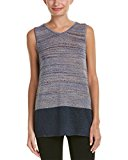

Product Title:  joan vass womens tank 0 
Euclidean Distance from input image: 37.3297
Amazon Url: www.amzon.com/dp/B06XXFBSP9


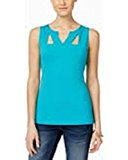

Product Title:  inc womens cutout split neck casual top blue l 
Euclidean Distance from input image: 37.3384
Amazon Url: www.amzon.com/dp/B01NAST7MR


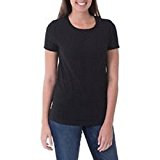

Product Title:  faded glory womens short sleeve crew neck tshirt black xlarge 
Euclidean Distance from input image: 37.3507
Amazon Url: www.amzon.com/dp/B06XHHTDRX


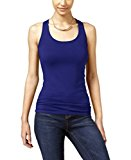

Product Title:  planet gold juniors racerback tank top blue large 
Euclidean Distance from input image: 37.3578
Amazon Url: www.amzon.com/dp/B0753L8DFS


In [20]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(13577, 20)
